# Coursework final

- Andy Yuan
- Aidan Dignam
- Amelia Walker
- Owen Stevenson


# Question 1

In [1]:
# Imports

import numpy as np
import polars as pl
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, MiniBatchKMeans

# Dimensionality reduction
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.manifold import TSNE

# Tree-based models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

# Model selection and evaluation
from sklearn.model_selection import (
    GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, 
    cross_validate, RepeatedKFold
)

from sklearn.metrics import (
    silhouette_samples, silhouette_score, confusion_matrix, 
    roc_curve, roc_auc_score, classification_report, accuracy_score, r2_score
)

# Preprocessing and feature selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# Linear models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import linear_model

# XGBoost
from xgboost import XGBRegressor, XGBClassifier

# Shap
import shap
shap.initjs() # Import Java engine.

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Statistical and optimization tools
from scipy.sparse import csr_matrix
from scipy.stats import zscore
from scipy.special import factorial
import scipy.optimize as so

# Text processing
import sklearn.feature_extraction.text as sktext
import re

# Dimensionality reduction
import umap.umap_ as umap

# Miscellaneous
import os
from itertools import chain, combinations
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import heapq


c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
householdspend = pl.read_csv("../Coursework Data/HouseholdSpend.csv")
demographics = pl.read_csv("../Coursework Data/DemoStats.csv")

In [ ]:
# Combine data on the CODE variable
data_combined = householdspend.join(demographics, on="CODE", how="full")

# Must split into train and test before doing any replacement, 
train_data, test_data = train_test_split(data_combined, train_size=0.7, random_state = 2025)

ColumnNotFoundError: "HSEP001" not found

In [23]:
# Dropping columns that were created from the merge
columns_to_drop = ["CODE", "CODE_right", "GEO", "GEO_right"]
ifexisting_cols = [col for col in columns_to_drop if col in data_combined.columns]
# Apply to train and test data
train_data = train_data.drop(ifexisting_cols)
test_data = test_data.drop(ifexisting_cols)

In [ ]:
# removing columns for clustering
response_columns = ["HSHNIAGG", "HSAGDISPIN", "HSAGDISCIN", # spending variables
                    "HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007"] # pension variables
ifexisting_response_cols = [col for col in response_columns if col in data_combined.columns]

# Apply to test and train data, create new variable to cluster
clustering_train = train_data.drop(ifexisting_response_cols)
clustering_test = test_data.drop(ifexisting_response_cols)
# Done so we can use the train_data and test_data later in regression
train_data["HSEP001"]

In [6]:
# identify which columns are strings
string_columns = train_data.select(pl.col(pl.Utf8())).columns

# Replace NA with median values of the columns converted to string, using train data median values
for col in string_columns:
    median = ( # median of train data
        train_data[col].replace("NA", None)
        .cast(pl.Float64)
        .median()
    )
    train_data = train_data.with_columns( # will be used for regression
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median)
        .alias(col)
    )
    clustering_train = clustering_train.with_columns( # for clustering only
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median) 
    )
    test_data = test_data.with_columns( # will be used for regression
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median) # fill with median of train data
    )
    clustering_test = clustering_test.with_columns( # for clustering only
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median) # fill with median of train data
    )

In [7]:
# Taking a look at the data, with response columns
train_data.describe()

statistic,HSBASHHD,HSHNIAGG,HSAGDISPIN,HSAGDISCIN,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,HSSH053,HSSH054,…,ECYRIMINDI,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,…,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",18.505115,2.2626e6,1.7238e6,1.2392e6,2.4116e6,2.2009e6,423209.823681,1.6131e6,390207.179942,279255.161129,111887.37018,109876.727277,76415.761653,272453.143834,88293.198336,45491.797261,71054.161279,34485.648004,3588.37441,70743.670012,25943.550577,33441.056207,115633.350406,48956.401378,210629.749926,67992.441264,4823.41001,113608.694673,15133.147703,9072.056276,390207.179942,304787.019089,89380.861689,88180.613863,87567.023167,613.590696,…,0.475481,0.005647,0.038527,0.008743,0.000294,0.007242,0.005139,0.002103,46.035674,31.880372,11.747136,4.725555,2.363264,1.391048,1.632757,1.634511,2.408166,46.035674,31.880372,11.747136,1.065733,2.036413,2.229684,5.291205,1.124101,2.408166,46.035674,14.158953,7.460665,24.416056,46.035674,40.689125,7.785901,32.903224,5.34655,0.854351,4.492198
"""std""",70.886858,8.4449e6,6.4618e6,4.7287e6,9.3466e6,8.2262e6,1.6205e6,6.0583e6,1.3965e6,1.0718e6,430183.638559,439069.769635,296558.361743,1.1009e6,333775.377327,167739.493808,252953.878919,116835.006737,14768.113483,268292.706488,97612.564862,130138.646141,439481.741856,211961.009232,1.3148e6,351657.299377,40380.835359,927454.989631,52136.466083,36694.039599,1.3965e6,1.0508e6,292767.24044,288406.910856,286399.843871,2381.414019,…,2.486168,0.125415,0.353543,0.139325,0.021105,0.117661,0.095502,0.055302,175.157275,152.949196,32.650807,14.38387,7.179114,4.583791,5.747218,5.720639,10.499825,175.157275,152.949196,32.650807,3.394052,6.080894,6.507734,14.823808,3.896334,10.499825,175.157275,39.981126,25.023536,134.439204,175.157275,167.258769,35.236248,133.355852,17.88653,3.168746,15.052397
"""min""",0.0,0.0,0.0,0.0,-24249.492537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4599e7,0.0,0.0,-1.6806e7,-26676.98553,-116332.638685,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",3.0,267155.787608,214057.554764,150195

## a. Data clean


In [7]:
# Scale data
scaler = StandardScaler()
clustering_train_scaled = pd.DataFrame(scaler.fit_transform(clustering_train.to_pandas()), columns=clustering_train.columns)
clustering_test_scaled = pd.DataFrame(scaler.transform(clustering_test.to_pandas()), columns=clustering_test.columns)

## b. K-means

### Clusterer and elbow

<bound method Visualizer.show of KElbowVisualizer(ax=<Axes: >,
                 estimator=KMeans(n_clusters=11, random_state=2025), k=(2, 12),
                 timings=False)>

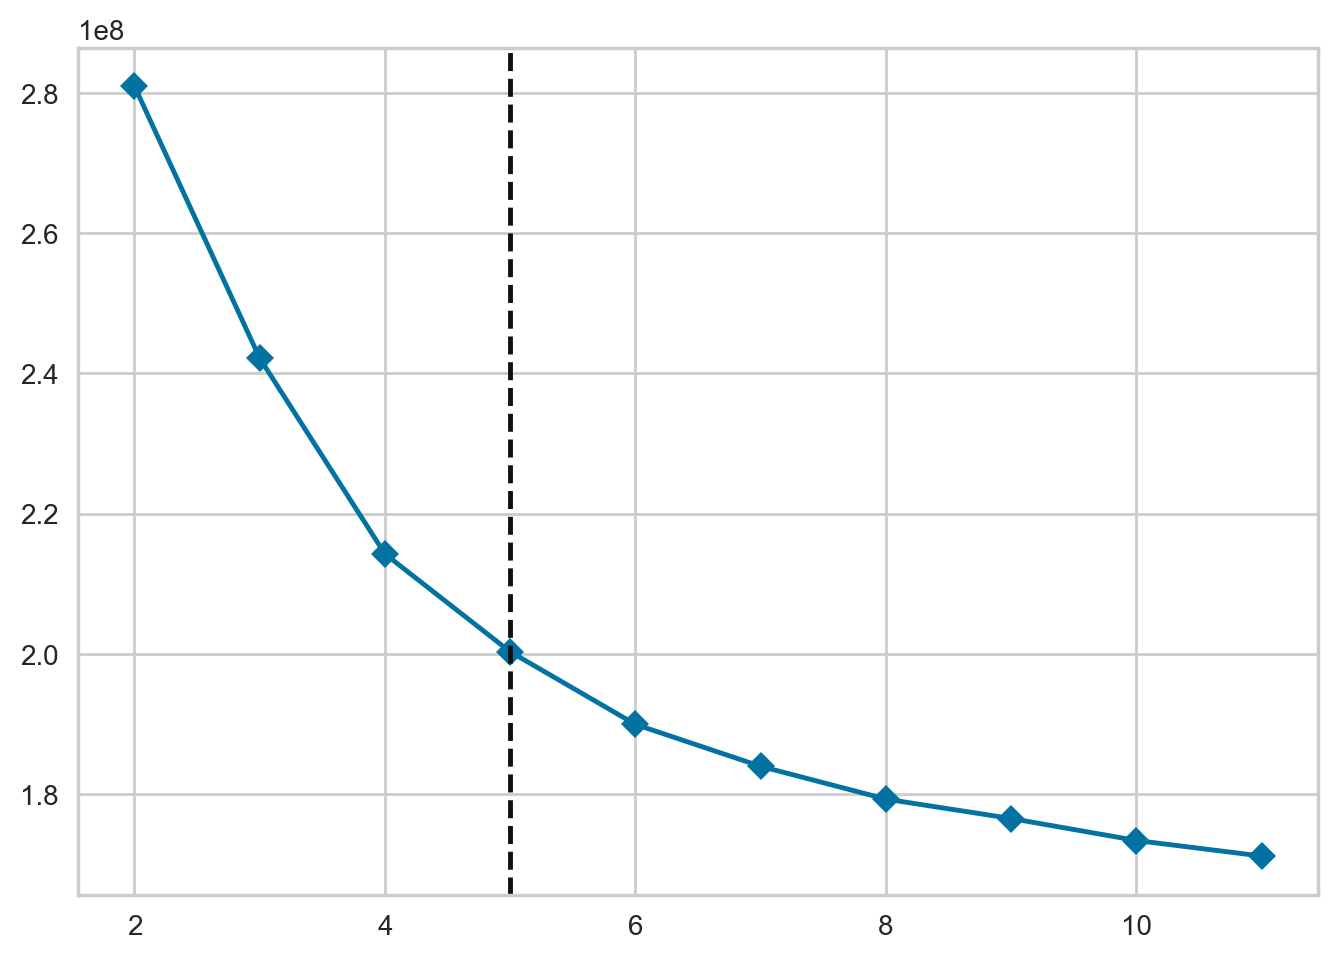

In [8]:
clustering_train_scaled_sample = clustering_train_scaled.sample(n=400000, random_state=2025) # sample for size of data set

# k-means clusterer created to use for visualizer
KClusterer = KMeans(n_clusters=3, # initialized with 3 for simplicity
                   verbose=0,
                   random_state=2025)

# Elbow visualizer
visualizer = KElbowVisualizer(KClusterer,
                              k=(2,12), # from 2 to 11 clusters
                              locate_elbow=True,
                              timings=False)
# Fit to scaled data sample
visualizer.fit(clustering_train_scaled_sample)
visualizer.show
## Chosen: 5 clusters

### Silhouette

In [ ]:
# Silhouette scorer
sil_scores = {}

for i in range(2,8):
    
    sample_scores = []
    
    for _ in range(10):
        current_sample = clustering_train_scaled.sample(n=10000, replace=False)
    
        Kmeansclusterer = KMeans(n_clusters=i,
                                verbose=0,
                                random_state=2025,
                                n_init=10)
        cluster_labels_silhouette = Kmeansclusterer.fit_predict(current_sample.values)
        sil_avg = silhouette_score(current_sample.values, cluster_labels_silhouette, n_jobs = -1)
        sample_scores.append(sil_avg)
        
    sil_scores[f'{i} clusters'] = np.mean(sample_scores)

print("Silhouette Scores:", sil_scores)
max_values = heapq.nlargest(3, sil_scores.values())
max_keys = [key for key, value in sil_scores.items() if value in max_values]
print("The greatest silhouette scores are from ", max_keys, "with scores of", max_values)

# Chosen: 2 clusters, decreases from there

Silhouette Scores: {'2 clusters': np.float64(0.9780328653196697), '3 clusters': np.float64(0.9095595099619643), '4 clusters': np.float64(0.6843688529565118), '5 clusters': np.float64(0.8073662794682746), '6 clusters': np.float64(0.5683395909320395), '7 clusters': np.float64(0.5543143473470017)}
The greatest silhouette scores are from  ['2 clusters', '3 clusters', '5 clusters'] with scores of [np.float64(0.9780328653196697), np.float64(0.9095595099619643), np.float64(0.8073662794682746)]


### Applying k-means according to best cluster number

In [9]:
# optimal kmeans function according to k-elbow and/or silhouette
KClusterer = KMeans(n_clusters=2, # put in optimal cluster amount
                   verbose=0,
                   random_state=2025)
# fitting to the training data (scaled)
KClusterer.fit(clustering_train_scaled)
# cluster means in unscaled units
unscaled_centroids = scaler.inverse_transform(KClusterer.cluster_centers_)
centroids_df = pd.DataFrame(unscaled_centroids, columns=clustering_train.columns)
print("Cluster Centroids (Original Units):\n", centroids_df)

# cluster assignments
train_cluster_labels = KClusterer.predict(clustering_train_scaled)
test_cluster_labels = KClusterer.predict(clustering_test_scaled)

# Create data_cluster_table for feature analysis
data_cluster_table = clustering_train.with_columns(
    pl.Series("cluster_label", train_cluster_labels)
)

Cluster Centroids (Original Units):
       HSBASHHD       HSTT001       HSTE001       HSTX001       HSTC001  \
0    16.819683  2.197195e+06  2.012861e+06  3.902858e+05  1.472132e+06   
1  1606.297674  2.043635e+08  1.793809e+08  3.143990e+07  1.344497e+08   

       HSSH001S      HSFD001S      HSHO001S      HSHC001S      HSHF001S  ...  \
0  3.589517e+05  2.539485e+05  1.017736e+05  9.939692e+04  6.963053e+04  ...   
1  2.983500e+07  2.411987e+07  9.639788e+06  9.982570e+06  6.468567e+06  ...   

   ECYGEN1GEN  ECYGEN2GEN   ECYGEN3GEN   ECYTCAHPOP    ECYTCACIT  ECYTCA_U18  \
0   13.758172    7.005026    21.044046    41.807244    36.580073    6.952011   
1  391.722481  436.703876  3201.079070  4029.505426  3911.696124  793.367442   

    ECYTCA_18P  ECYNCANCIT  ECYNCA_U18  ECYNCA_18P  
0    29.628062    5.227171    0.835483    4.391688  
1  3118.328682  117.809302   18.629457   99.179845  

[2 rows x 975 columns]


## c. Linear dimensionality reductions

### i. Applying PCA

In [10]:
## PCA
nPCA = PCA(n_components=10)
nPCA.fit(np.asarray(clustering_train_scaled))
total_variance = np.sum(nPCA.explained_variance_ratio_) * 100
print('The total explained variance of the first %i components is %.3f percent' % (nPCA.n_components_, total_variance))

The total explained variance of the first 10 components is 69.843 percent


### ii. Plot the data of the first two PCs in a scatterplot (scaled data)

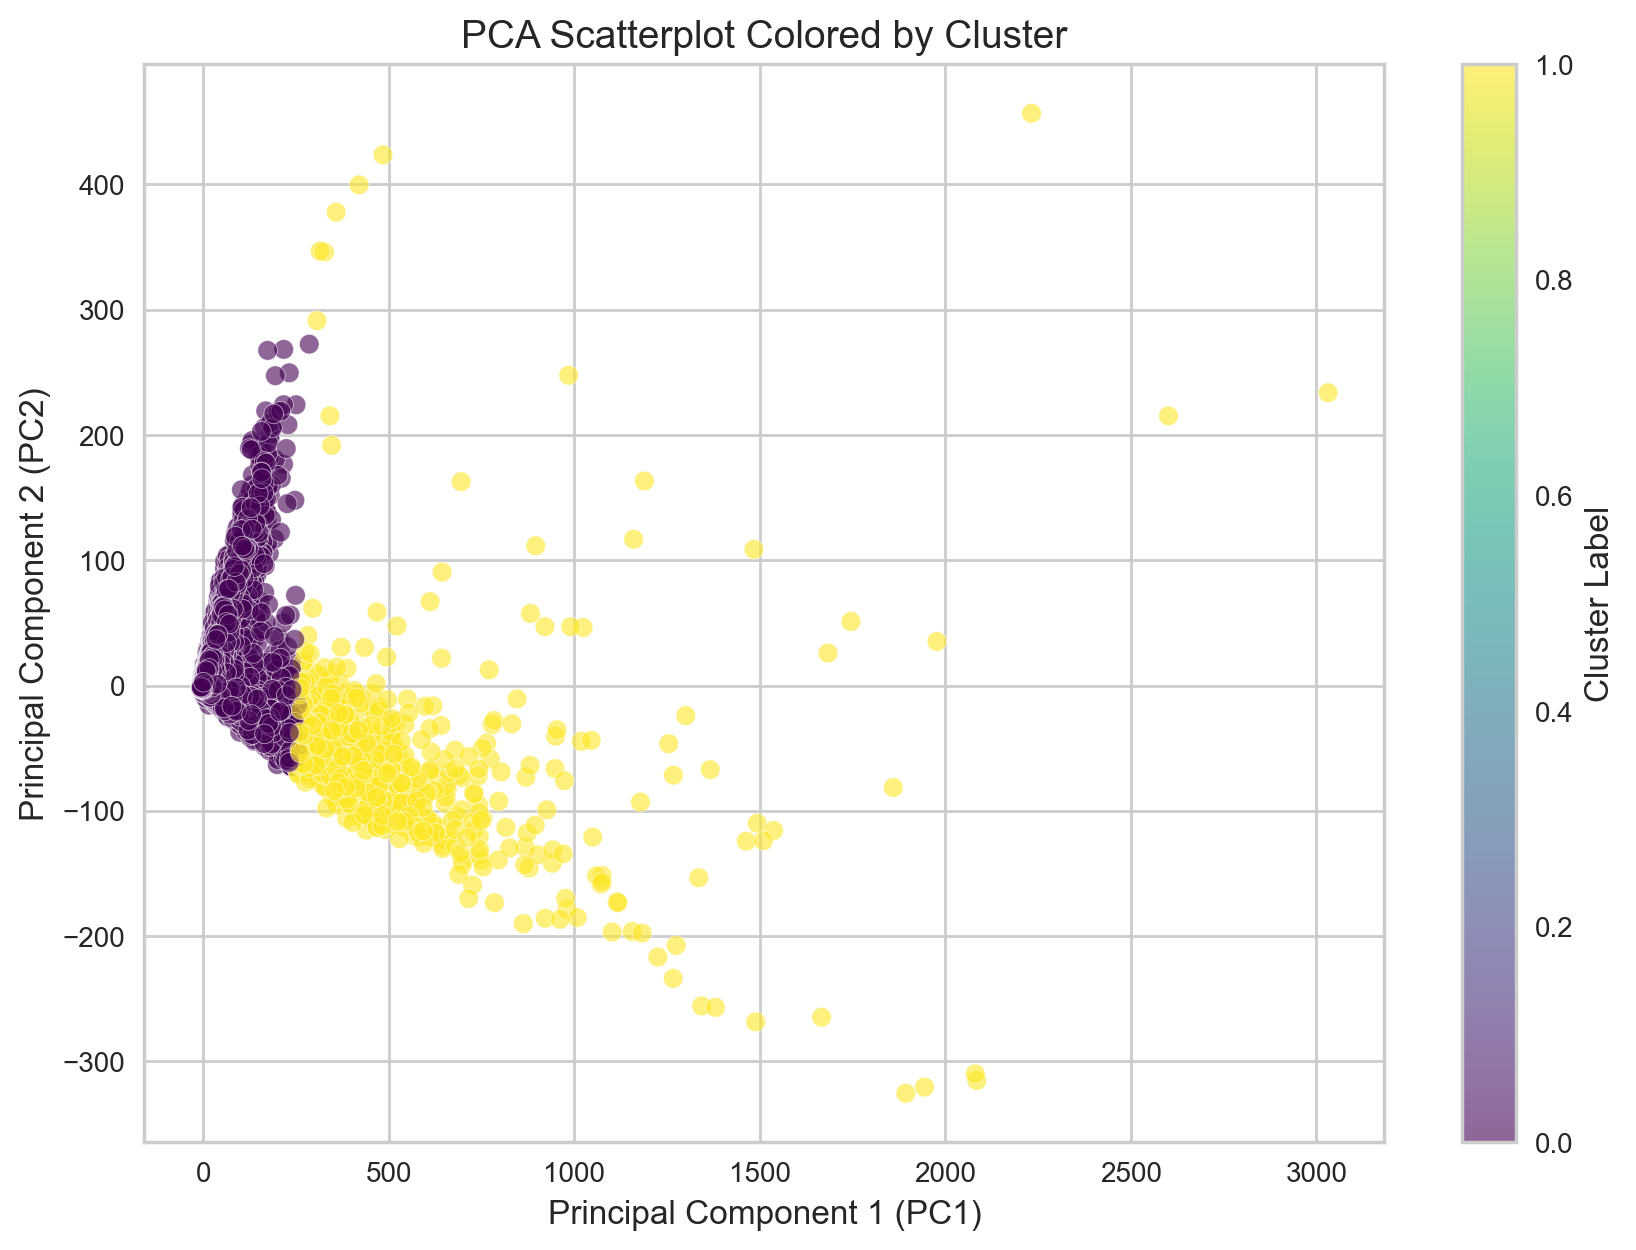

In [11]:
# Plot the data of the first two PCs in a scatterplot (scaled data)
pca_components = nPCA.transform(np.asarray(clustering_train_scaled))
pc1 = pca_components[:, 0]  # First principal component
pc2 = pca_components[:, 1]  # Second principal component
pc3 = pca_components[:, 2]  # Third principal component

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pc1, 
    pc2, 
    c=train_cluster_labels, 
    cmap='viridis',  # You can change to 'plasma', 'rainbow', etc.
    alpha=0.6,       # Slightly transparent points
    edgecolors='w',  # White edges for better visibility
    s=50            # Point size
)

plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
plt.title('PCA Scatterplot Colored by Cluster', fontsize=14)

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label', fontsize=12)

plt.show()

### Interpretation

eiosdfgjiopefoaishrgipjgwrig9upafg98 249tu 490u ridgjkl sdfgajkln dg890 wet4t 24wt 

### iii. Calculate average value of first three components, put into table

In [12]:
# Calculate average value of first three components, put into table
pca_df = pd.DataFrame({
    'PC1': pc1,
    'PC2': pc2,
    'PC3': pc3,
    'Cluster': train_cluster_labels # from KClusterer.fit(clustering_train_scaled)
})

# 1. Get PCA loadings (feature contributions)
loadings = pd.DataFrame(
    nPCA.components_.T[:, :3],
    columns=['PC1', 'PC2', 'PC3'],
    index=clustering_train.columns
)

pca_cluster_means = pca_df.groupby('Cluster').mean().reset_index()
feature_means = data_cluster_table.group_by("cluster_label").mean()

def name_cluster(row):
    # Find dominant PC
    pc_scores = {'PC1': row['PC1'], 'PC2': row['PC2'], 'PC3': row['PC3']}
    dominant_pc = max(pc_scores.keys(), key=lambda k: abs(pc_scores[k]))
    
    # Get top 3 features for this PC
    top_features = loadings[dominant_pc].abs().nlargest(3).index.tolist()
    
    # Describe feature trends
    trends = []
    for feat in top_features:
        feat_mean = feature_means.select(pl.col(feat)).mean().item()
        cluster_feat_val = feature_means.filter(pl.col("cluster_label") == row['Cluster']).select(feat).item()
        trend = "High" if cluster_feat_val > feat_mean else "Low"
        trends.append(f"{trend} {feat}")
    
    direction = "High" if pc_scores[dominant_pc] > 0 else "Low"
    return f"{direction} {dominant_pc} ({', '.join(trends)})"

# Apply naming and merge results
pca_cluster_means['Cluster_Name'] = pca_cluster_means.apply(name_cluster, axis=1)
final_results = pca_cluster_means.merge(
    feature_means.to_pandas(), 
    left_on='Cluster',
    right_on='cluster_label'
)

print("PCA Component Averages with Cluster Interpretation:")
print(pca_cluster_means[['Cluster', 'Cluster_Name', 'PC1', 'PC2', 'PC3']])

print("\nDetailed Feature Means per Cluster:")
display(feature_means.to_pandas().style.background_gradient(cmap='Blues'))

PCA Component Averages with Cluster Interpretation:
   Cluster                                       Cluster_Name         PC1  \
0        0  Low PC1 (Low ECYBAS12HP, Low ECYPNIHP15, Low E...   -0.542833   
1        1  High PC1 (High ECYBAS12HP, High ECYPNIHP15, Hi...  511.385383   

         PC2       PC3  
0   0.060209 -0.003829  
1 -56.721016  3.607111  

Detailed Feature Means per Cluster:


## d. UMAP

### Choice of parameters

In [15]:
# best parameters to use:

# Define parameter grid
param_grid = {
    'n_neighbors': [5, 15, 30, 50],
    'min_dist': [0.01, 0.1, 0.5],
    'metric': ['euclidean', 'cosine']
}

clustering_train_scaled_sample = clustering_train_scaled.sample(n=10000, random_state=2025)
jittered_clustering = clustering_train_scaled_sample + np.random.normal(0, 1e-5, clustering_train_scaled_sample.shape)
train_labels_umap = KClusterer.predict(jittered_clustering)

best_score = -1
best_params = {}
best_embedding = None

# Grid search (small-scale for demonstration)
for n in param_grid['n_neighbors']:
    for d in param_grid['min_dist']:
        for m in param_grid['metric']:
            reducer = umap.UMAP(n_neighbors=n, min_dist=d, metric=m, random_state=2025, n_jobs=1, verbose=0)
            embedding = reducer.fit_transform(jittered_clustering)
            score = silhouette_score(embedding, train_labels_umap)
            if score > best_score:
                best_score = score
                best_params = {'n_neighbors': n, 'min_dist': d, 'metric': m}
                best_embedding = embedding

print(f"Best parameters: {best_params}, Silhouette score: {best_score:.3f}")

c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-pack

Best parameters: {'n_neighbors': 5, 'min_dist': 0.1, 'metric': 'euclidean'}, Silhouette score: 0.285


### Plot UMAP

c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


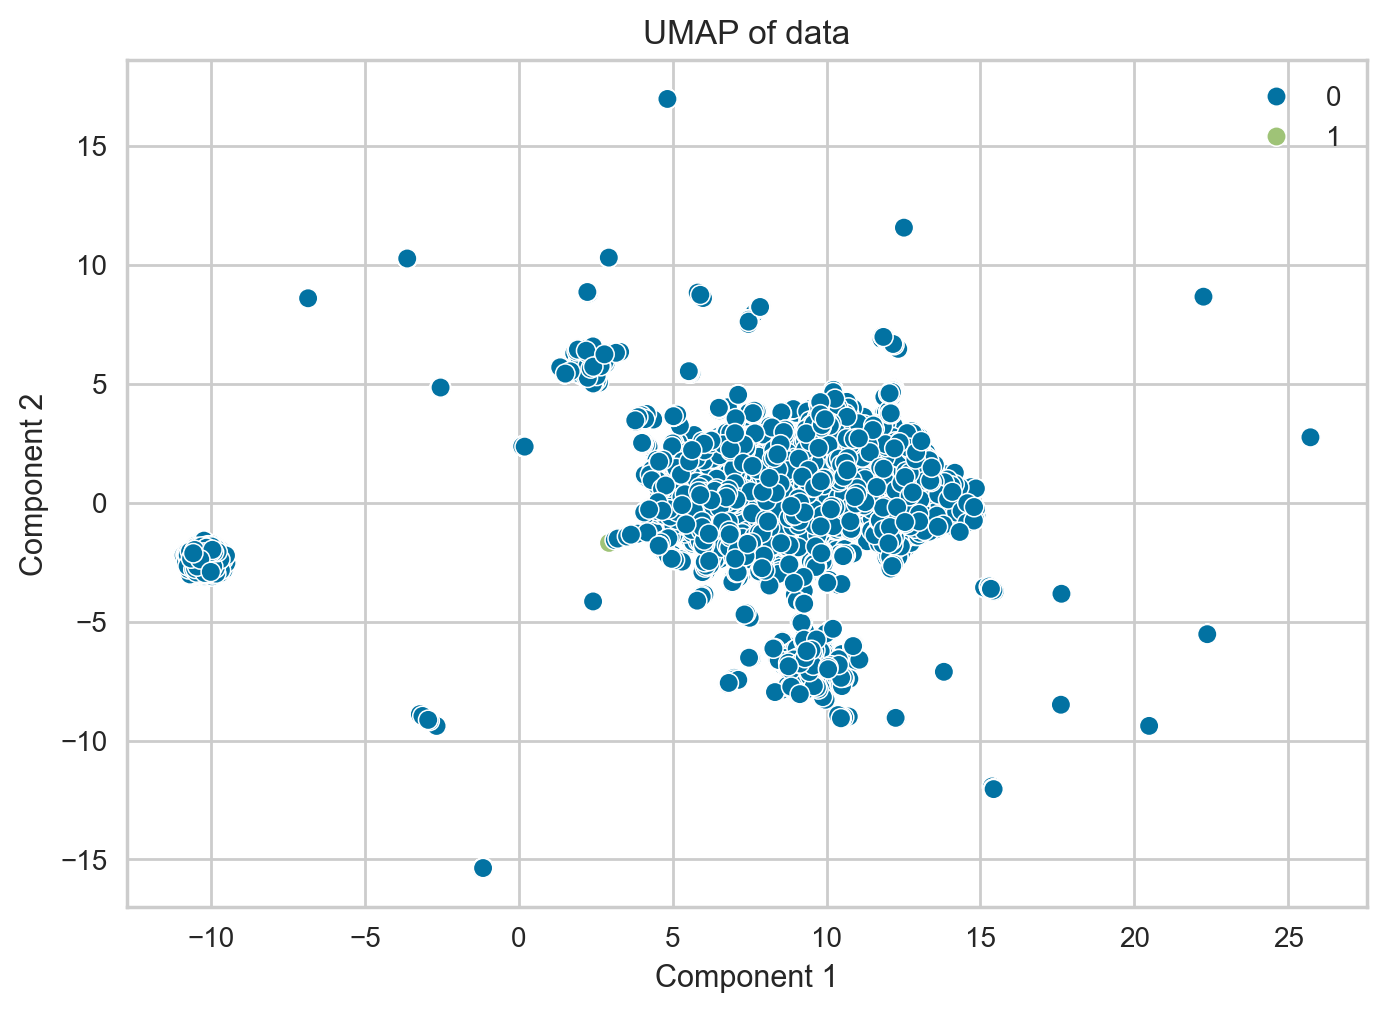

In [17]:
reducer = umap.UMAP(n_neighbors=5,              # Number of neareast neighbours to use. (set to best)
                    n_components=2,              # Number of components. UMAP is robust to larger values
                    metric='euclidean',             # Metric to use. (set to best)
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.1,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness. (set to best)
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=False,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    verbose=0                 # Verbosity
                   )
UMAP_embedding = reducer.fit_transform(jittered_clustering)

sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=train_labels_umap)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of data")
plt.show()

# Question 2


## a. Regularized elastic net regularized linear regression

In [ ]:
# Target variable creation (proportion of income spent on total personal insurance premiums and retirement/pension contributions)
# personal insurance and pension columns
personal_insur_pension_col = ["HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007"]
# checking if they exist
ifexisting_response_cols = [col for col in personal_insur_pension_col if col in train_data.columns]
print(ifexisting_response_cols)

median = ( # median of train data
        train_data["HSHNIAGG"]
        .replace(0, None)
        .median()
    )
print(median)
# Filling 0 with median of spend from train data
train_data = train_data.with_columns( 
    pl.col("HSHNIAGG").replace(0, median)
    .fill_null(median)
    .alias("HSHNIAGG")
)
# Filling 0 with median of spend from train data
test_data = test_data.with_columns(
    pl.col("HSHNIAGG").replace(0, median)
    .fill_null(median)
    .alias("HSHNIAGG")
)

# Create response for train data
train_data = train_data.with_columns(
    (pl.sum_horizontal(ifexisting_response_cols).fill_null(0) / pl.col("HSHNIAGG"))
    .alias("Proportion_spend")
)
# Create response for test data
test_data = test_data.with_columns(
    (pl.sum_horizontal(ifexisting_response_cols).fill_null(0) / pl.col("HSHNIAGG"))
    .alias("Proportion_spend")
)

ColumnNotFoundError: "HSEP001" not found